In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tikzplotlib

#check website https://jwalton.info/Embed-Publication-Matplotlib-Latex/
#plt.style.use('seaborn')
params = {# Latex
        "text.usetex": True,
        "font.family": "serif",
        "font.serif" : ["Computer Modern Serif"],
        # Font size (adpated to the size of my master's thesis which is of 12pts)
        "axes.labelsize": 12,
        "font.size": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        # Color of ticks and labels
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        }
plt.rcParams.update(params)

In [2]:
# text width of my latex document
width = 505.89 # text width of my latex document is 505.89pt. 

# Function taken from: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

## Import data

In [3]:
df = pd.read_csv('150928.csv', usecols=["Time", " LFmeasurement0", " ISCO1FlowRate", " ISCO2FlowRate"], dtype = {'Time': int})
df.rename(columns={' LFmeasurement0': 'Pressure', ' ISCO1FlowRate': 'ISCO1FlowRate', ' ISCO2FlowRate': 'ISCO2FlowRate'}, inplace=True)
df.head(3)

,Time,Pressure,ISCO1FlowRate,ISCO2FlowRate
0,150929,0.249,0.0,0.0
1,150930,0.249,0.0,0.0
2,150931,0.249,0.0,0.0


## Data processing

#### Processing of time

In [4]:
def HourMinuteSecond_to_Second(t, t_ini):
    """Function to convert csv time format to second. 
    In fact the computer is recording every second so not very useful function but keep in case."""
    # split time into Hour, Minutes and Second
    t_split, t_ini_split = [], []
    for i in range(len(str(t)), 0 , -2):
        t_split.append(str(t)[i-2:i])
        t_ini_split.append(str(t_ini)[i-2:i])
    # compute time in second
    t_s = int(t_split[0]) + int(t_split[1])*60 + int(t_split[2])*3600
    t_ini_s = int(t_ini_split[0]) + int(t_ini_split[1])*60 + int(t_ini_split[2])*3600
    # compute delta time in second
    return t_s - t_ini_s

In [5]:
# from Time column get delta time since the beginning of the experiment in second
df.Time = df["Time"].apply(HourMinuteSecond_to_Second, t_ini = df.Time[0])

#### Processing of pressure

In [6]:
# we need to sustract the initial offset from pressure data
df.Pressure = df["Pressure"].apply(lambda x: (x-df.Pressure[0]))
df.head(3)

,Time,Pressure,ISCO1FlowRate,ISCO2FlowRate
0,0,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,2,0.0,0.0,0.0


#### Processing of flow rate

In [7]:
# small check to know which flows have been used during the experiment
df.ISCO1FlowRate.value_counts()[df.ISCO1FlowRate.value_counts()>10]

 0.000      6541
 0.050       520
 0.500       436
 0.250       217
 0.025       190
 0.400        64
 0.100        52
 2.500        22
-107.000      14
Name: ISCO1FlowRate, dtype: int64

In [8]:
df.ISCO2FlowRate.value_counts()[df.ISCO2FlowRate.value_counts()>10]

 0.000      6549
 0.250       217
 0.500       214
 0.025       193
 0.050       137
 1.000       103
 0.400        64
 2.500        22
-107.000      12
 0.435        11
Name: ISCO2FlowRate, dtype: int64

In [9]:
# using the information from the last two cells we can define a list of possible flow rates for the pumps
possible_ISCO_flow_list = [0.000, 0.050, 0.500, 0.250, 0.025, 0.400, 0.100, 2.500, 1.000]

In [10]:
def FlowInjected(ISCO1FlowRate, ISCO2FlowRate):
    """Function to get real flow rate imposed during the experiment"""
    FlowRate_sum = ISCO1FlowRate + ISCO2FlowRate
    for possible_ISCO_flow in possible_ISCO_flow_list:
        #if FlowRate_sum == 2*possible_ISCO_flow:
        if abs(FlowRate_sum - 2*possible_ISCO_flow)<0.0001:
            return FlowRate_sum
        
    for possible_ISCO_flow in possible_ISCO_flow_list:  
        if ISCO1FlowRate == possible_ISCO_flow:
            return ISCO1FlowRate
    
    return ISCO2FlowRate

In [11]:
df["FlowRate"] = df.apply(lambda row: FlowInjected(row.ISCO1FlowRate, row.ISCO2FlowRate), axis=1)

<Axes: >

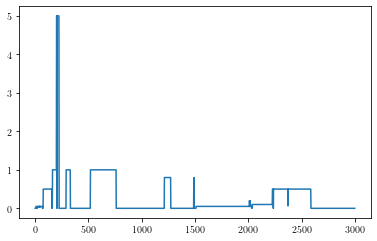

In [12]:
df["FlowRate"][0:3000].plot(figsize=set_size(width, fraction=0.9))

<Axes: >

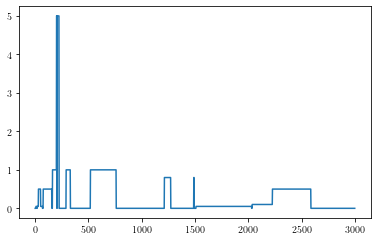

In [13]:
# other small data cleaning manually
import warnings
warnings.filterwarnings('ignore')

df.loc[30:50, "FlowRate"]=0.5
df.loc[2000:2020, "FlowRate"]=0.05
df["FlowRate"][2235] = 0.5
df["FlowRate"][2373] = 0.5
df["FlowRate"][0:3000].plot(figsize=set_size(width, fraction=0.9))

#### Calculation of volume injected

In [14]:
df["VolumeInjected"] = df.FlowRate.cumsum(axis = 0)/60. #devide by 60 because flow rate is in mL/min and we need it in mL/s

## Data visualization

#### Data from experiment 

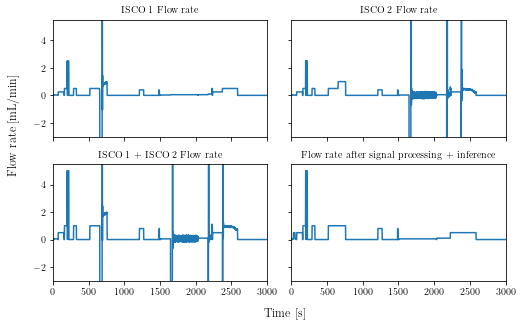

In [15]:
# process of flow data
# remark: this plot is more complicated so we set the font manually knowing that the latex text size is 12pts
fig, ax = plt.subplots(2, 2, figsize=set_size(width, fraction=1), sharey = True, sharex = True) #figsize= (18,11)
ax[0, 0].plot(df["Time"], df["ISCO1FlowRate"])
ax[0, 0].set_title("ISCO 1 Flow rate", fontsize=10)
ax[0, 1].plot(df["Time"], df["ISCO2FlowRate"])
ax[0, 1].set_title("ISCO 2 Flow rate", fontsize=10)
SumFlowRate = df["ISCO1FlowRate"]+df["ISCO2FlowRate"]
#SumFlowRate[SumFlowRate < 0] = 0 #replace all negative values with 0
ax[1, 0].plot(df["Time"], SumFlowRate)
ax[1, 0].set_title("ISCO 1 + ISCO 2 Flow rate", fontsize=10)
ax[1, 1].plot(df["Time"], df["FlowRate"])
ax[1, 1].set_title("Flow rate after signal processing + inference", fontsize=10)

ax[0, 0].set_xlim(0, 3000)
ax[0, 0].set_ylim(-3, 5.5)
fig.text(0.48,-0.03, "Time [s]", fontsize=12)
fig.text(-0.03,0.43, "Flow rate [mL/min]", rotation = 90, fontsize=12)
    
fig.tight_layout()

#save in png high quality for google slides
plt.savefig("FlowRate.png", format="png", bbox_inches="tight", dpi=600)

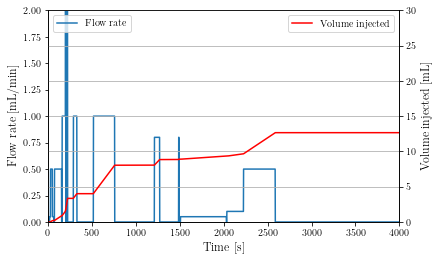

In [16]:
# flow rate vs volume injected
fig, ax1 = plt.subplots(figsize=set_size(width, fraction=0.9))
ax1.plot(df["Time"], df["FlowRate"]) 
ax1.set_xlabel('Time [s]')
ax1.set_xlim(0, 4000)
ax1.set_ylabel('Flow rate [mL/min]')
ax1.set_ylim(0, 2)
ax1.legend(['Flow rate'], loc="upper left")

ax2 = ax1.twinx()# plot bar chart on axis #2
ax2.plot(df["Time"], df["VolumeInjected"], color='red')
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('Volume injected [mL]')
ax2.set_ylim(0, 30)
ax2.legend(['Volume injected'], loc="upper right")

plt.grid(True)

#save in png high quality for google slides
plt.savefig("Volume.png", format="png", bbox_inches="tight", dpi=1000)

plt.show()

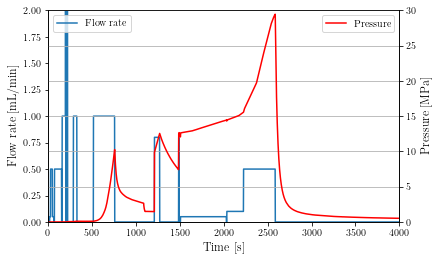

In [17]:
# flow rate vs pressure
fig, ax1 = plt.subplots(figsize=set_size(width, fraction=0.9))
ax1.plot(df["Time"], df["FlowRate"]) 
ax1.set_xlabel('Time [s]')
ax1.set_xlim(0, 4000)
ax1.set_ylabel('Flow rate [mL/min]')
ax1.set_ylim(0, 2)
ax1.legend(['Flow rate'], loc="upper left")

ax2 = ax1.twinx()# plot bar chart on axis #2
ax2.plot(df["Time"], df["Pressure"], color='red')
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('Pressure [MPa]')
ax2.set_ylim(0, 30)
ax2.legend(['Pressure'], loc="upper right")

plt.grid(True)

#save in png high quality for google slides
plt.savefig("Pressure.png", format="png", bbox_inches="tight", dpi=1000)

plt.show()

#### Computation of permeability from first pulse

intercept:  -439.67614966948116 
 slope:  67.80442693021052


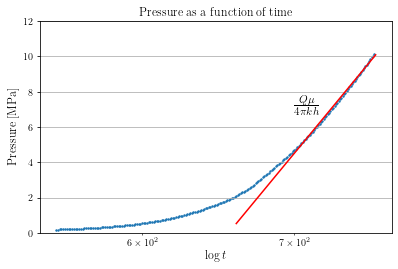

In [18]:
# drawdown 

#data
fig1, ax1 = plt.subplots(figsize=set_size(width, fraction=0.9))
ax1.scatter(df["Time"][550:760], df["Pressure"][550:760], s=2) 

#linear regression
#careful: apply log to x before computing the polyfit
b, a = np.polyfit(np.log(df["Time"][700:760]), df["Pressure"][700:760], deg=1)
print("intercept: ", a, "\n", "slope: ", b)
x_vec = [df["Time"][660], df["Time"][760]]
y_vec = [a+b*np.log(df["Time"][660]), a+b*np.log(df["Time"][760])]
ax1.plot(x_vec, y_vec, color="r")
ax1.text(700, 7, r"$\frac{Q \mu}{4\pi k h}$", fontsize=16)

ax1.set_xscale('log')
ax1.set_xlabel(r'$\log{t}$')
#ax1.set_xlim(550, 760)
ax1.set_ylabel('Pressure [MPa]')
ax1.set_ylim(0, 12)
ax1.set_title('Pressure as a function of time')

plt.grid(True)

#save in png high quality for google slides
plt.savefig("Drawdown.png", format="png", bbox_inches="tight", dpi=1000)

plt.show()

In [19]:
# compute transmissibility
Q = 1/6e+7 # flow in [m^3/s]: /6e+7 to go from mL/min to m³/s
mu = 8.90e-4 # dynamic viscosity of water in [Pa*s]
Transmissibility_drawdown = (Q*mu)/(4*np.pi*b)
print(Transmissibility_drawdown)

1.7408880433129345e-14


intercept:  1.2756521217564993 
 slope:  1.191494280871862


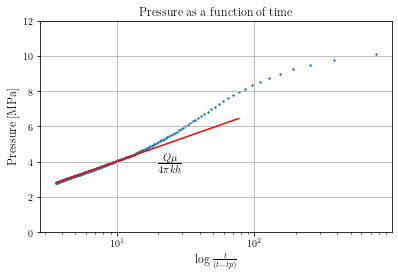

In [20]:
#horner
tp = 760 # check visually the time for which the pressure is max
fig2, ax2 = plt.subplots(figsize=set_size(width, fraction=0.9))
ax2.scatter(df["Time"][760:1050]/(df["Time"][760:1050]-tp), df["Pressure"][760:1050], s=2) 

#linear regression
#careful: apply log to x before computing the polyfit
b, a = np.polyfit(np.log(df["Time"][900:1050].iloc[::-1]/(df["Time"][900:1050].iloc[::-1]-tp)), df["Pressure"][900:1050].iloc[::-1], deg=1)
#ax2.scatter(df["Time"][900:1050].iloc[::-1]/(df["Time"][900:1050].iloc[::-1]-tp), df["Pressure"][900:1050].iloc[::-1], s=2, c="r") 
print("intercept: ", a, "\n", "slope: ", b)
x_vec = [df["Time"][1050]/(df["Time"][1050]-tp), df["Time"][770]/(df["Time"][770]-tp)]
y_vec = [a+b*np.log(df["Time"][1050]/(df["Time"][1050]-tp)), a+b*np.log(df["Time"][770]/(df["Time"][770]-tp))]
ax2.plot(x_vec, y_vec, color="r")
ax2.text(20, 3.7, r"$\frac{Q \mu}{4\pi k h}$", fontsize=15)

ax2.set_xscale('log')
ax2.set_xlabel(r'$\log{\frac{t}{(t-tp)}}$')
#ax2.set_xlim(760, 1050)
ax2.set_ylabel('Pressure [MPa]')
ax2.set_ylim(0, 12)
ax2.set_title('Pressure as a function of time')

plt.grid(True)

#save in png high quality for google slides
plt.savefig("Horner.png", format="png", bbox_inches="tight", dpi=1000)

plt.show()

In [21]:
# compute transmissibility
Transmissibility_horner = (Q*mu)/(4*np.pi*b)
print(Transmissibility_horner)

9.906880630607368e-13


## Template for plotting

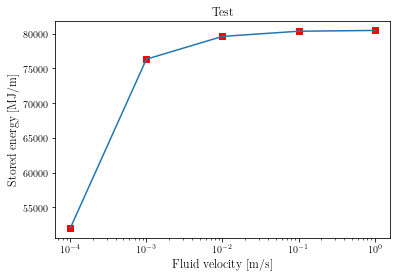

In [22]:
# this data has been saved "by hand" by looking at the stored energy for each simulation for a given velocity
v = [0.0001, 0.001, 0.01, 0.1, 1.]
E = [52021, 76336, 79617, 80361, 80477]
plt.scatter(v, E, marker='s', c='r')
plt.plot(v, E)
plt.xscale('log')
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
plt.xlabel('Fluid velocity [m/s]') #, fontsize=15)
plt.ylabel('Stored energy [MJ/m]')  #, fontsize=15) 
plt.title('Test')

#save in svg (in the lab they use .eps format but it's the same as svg)
plt.savefig("test.svg", format="svg", bbox_inches="tight")

#save in png high quality for google slides
plt.savefig("test.png", format="png", bbox_inches="tight", dpi=1000)

#save in tex for report
tikzplotlib.clean_figure()
tikzplotlib.save('test.tex')

#show
plt.show()